In [2]:
import warnings
warnings.filterwarnings('ignore')

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [19]:
import numpy as np

import tensorflow as tf

from tqdm.keras import TqdmCallback

from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [4]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

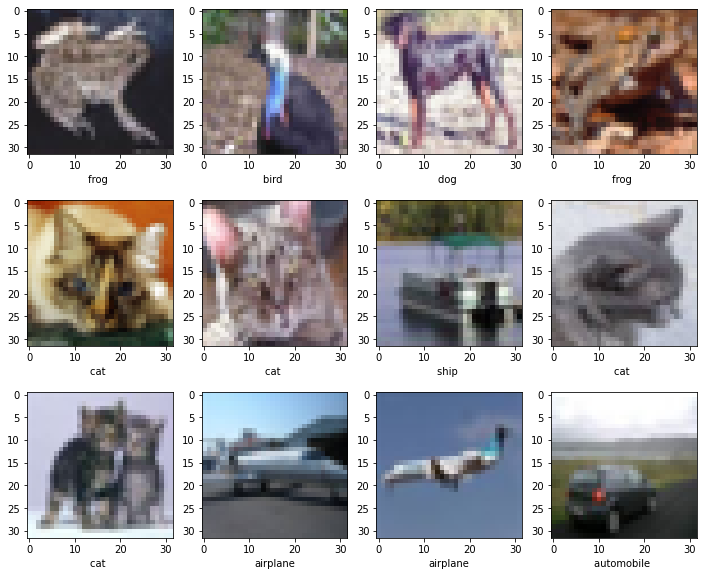

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [6]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [7]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [8]:
import keras
from keras import layers as L
from keras import backend as K

In [9]:
model = tf.keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3, )))
model.add(L.Flatten())
model.add(L.Dense(200, activation = 'relu'))
model.add(L.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               614600    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________


In [10]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [11]:
y_train, y_val = (keras.utils.np_utils.to_categorical(y) for y in (y_train, y_val))

In [12]:
# one hot encode outputs

#y_train = np_utils.to_categorical(y_train)

y_test_t = keras.utils.np_utils.to_categorical(y_test)
class_num = y_test_t.shape[1]

In [13]:
print(f"Training set: {X_train.shape} and {y_train.shape}")
print(f"Validation set: {X_val.shape} and {y_val.shape}")
print(f"Testing set: {X_test.shape} and {y_test.shape}")

Training set: (40000, 32, 32, 3) and (40000, 10)
Validation set: (10000, 32, 32, 3) and (10000, 10)
Testing set: (10000, 32, 32, 3) and (10000, 1)


In [20]:
callbacks = [TqdmCallback(verbose=1)]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=keras.metrics.categorical_accuracy)
model.fit(X_train, y_train, epochs=100, verbose=0, callbacks = callbacks)

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [22]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5147
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [23]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3, )))
model.add(L.Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Flatten())
model.add(L.Dense(100, activation="relu"))
model.add(L.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               225100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 226,390
Trainable params: 226,390
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=keras.metrics.categorical_accuracy)
model.fit(X_train, y_train, epochs=100, verbose=0, callbacks=callbacks)

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [25]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5793
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [26]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=-1))))

In [27]:
!rm -rf ./logs

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [30]:
# вариант № 1

# optimizers = {
#     'Adam': tf.keras.optimizers.Adam(learning_rate=0.1),
#     'SGD': tf.keras.optimizers.SGD(learning_rate=0.1),
#     'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=0.1)
# }

In [28]:
# вариант № 2

optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
}

In [29]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

Final score of single_model_Adam is 0.5477
Final score of single_model_SGD is 0.5776
Final score of single_model_Adadelta is 0.391


### Прокомментируйте полученные результаты.

Оптимизатор - это то, что настроит веса в вашей сети так, чтобы приблизиться к точке с наименьшими потерями. 

Алгоритм Адама является одним из наиболее часто используемых оптимизаторов, потому что он дает высокую производительность в большинстве задач.

Стохастический оптимизатор градиентного спуска.
Включает в себя поддержку импульса, затухания скорости обучения и импульса Нестерова.

Adadelta — более надежное расширение Adagrad, которое адаптирует скорость обучения на основе скользящего окна обновления градиентов, вместо того, чтобы накапливать все градиенты прошлых лет. Таким образом, Adadelta продолжает обучение даже тогда, когда сделано много обновлений. 


ADAM — это просто Adadelta (который перемасштабирует градиенты на основе накопленной информации «второго порядка») плюс импульс (который сглаживает градиенты на основе накопленной информации «первого порядка»). т.е. ADAM — это расширение Adadelta, которое возвращается к Adadelta при определенных настройках гиперпараметров.
 
Если мы отключим сглаживание первого порядка в ADAM, мы останемся с Adadelta. Если мы отключим масштабирование второго порядка, у нас останется старый добрый SGD + импульс. Независимо от того, используете ли мы ADAM или Adadelta, мы все равно будем настраивать скорость обучения. Сказать иначе было бы наивно.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [30]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...


In [35]:
# Вариант № 1

# models = Models(keras.Sequential())
# models.add(keras.Input(shape=(32, 32, 3, )))
# models.add(L.Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
# models.add(L.MaxPooling2D(pool_size=(2,2)))
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Flatten())
# models.add(L.Dense(100, activation="relu"))
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Dense(10, activation="softmax"))
# models.add_create('conv_batchnorm', L.BatchNormalization())


In [31]:
# Вариант № 2

models = Models(keras.Sequential())
models.add(keras.Input(shape=(32, 32, 3, )))
models.add(L.Conv2D(filters=10, kernel_size=(3,3)))
models.add(L.MaxPooling2D(pool_size=(2,2)))
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Flatten())
models.add(L.Dense(100, activation="relu"))
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Dense(10, activation="softmax"))



In [32]:
models

Models([('base_model', <keras.engine.sequential.Sequential at 0x1e00a28aee0>),
        ('conv_batchnorm',
         <keras.engine.sequential.Sequential at 0x1e007f7ae20>)])

In [36]:
# # вариант № 1

# optimizers = {
#     'Adam': tf.keras.optimizers.Adam(learning_rate=0.1),
#     'SGD': tf.keras.optimizers.SGD(learning_rate=0.1),
#     'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=0.1)
# }

In [33]:
# вариант № 2

optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
}

In [34]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/6 [00:00<?, ?it/s]

Final score of base_model_Adam is 0.569
Final score of base_model_SGD is 0.5834
Final score of base_model_Adadelta is 0.4291
Final score of conv_batchnorm_Adam is 0.1
Final score of conv_batchnorm_SGD is 0.1
Final score of conv_batchnorm_Adadelta is 0.0716


### Прокомментируйте полученные результаты.

Ожидалось, что качество будет равным или выше, после добавления приведение к единому виду, 
Но эффект получился обратный,
Причины остались не понятны >_< 

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [74]:
# callbacks = [EarlyStopping(monitor='categorical_accuracy', mode='min', verbose=1, patience=80, baseline=0.55)]

In [89]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=25, min_delta=0.001, verbose=1, baseline=0.55)]

In [90]:
for batch_size in [32, 64, 128, 256]:
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(32, 32, 3, )))
    model.add(L.Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.BatchNormalization())
    model.add(L.Flatten())
    model.add(L.Dense(100, activation="relu"))
    model.add(L.BatchNormalization())
    model.add(L.Dense(10, activation="softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0, callbacks=callbacks, batch_size=batch_size)
    results = model.evaluate(X_test, y_test_t, verbose=0)
    print(f"A model with batch size {batch_size} reached an accuracy of {round(results[1]*100, 2)}% after {history.epoch[-1]} epochs.")

Epoch 00037: early stopping
A model with batch size 32 reached an accuracy of 55.96% after 36 epochs.
Epoch 00042: early stopping
A model with batch size 64 reached an accuracy of 57.39% after 41 epochs.
Epoch 00049: early stopping
A model with batch size 128 reached an accuracy of 54.29% after 48 epochs.
Epoch 00062: early stopping
A model with batch size 256 reached an accuracy of 57.69% after 61 epochs.


### Прокомментируйте полученные результаты.

При batch size 32, 64, 256 удалось достигнуть accuracy больше 55 % на простой модели, 
Можем предположить, что сильно маленькое или большое значение batch size могут не принести должного результата, следует искать золотую середину.


С течением времени алгоритм наклоняется, и его ошибка на тренировочном наборе естественным образом уменьшается, как и его ошибка на проверочном наборе. Однако через некоторое время ошибка валидации перестает уменьшаться и фактически начинает снова расти. Это указывает на то, что модель начала соответствовать обучающим данным. При ранней остановке сеть просто прекращает тренировку, как только ошибка проверки достигает минимума.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [65]:
import matplotlib.pyplot as plt

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 15, 15, 10)        0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 15, 15, 10)        40        
_________________________________________________________________
flatten_60 (Flatten)         (None, 2250)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 100)               225100    
_________________________________________________________________
batch_normalization_70 (Batc (None, 100)               400       
_________________________________________________________________
dense_121 (Dense)            (None, 10)              

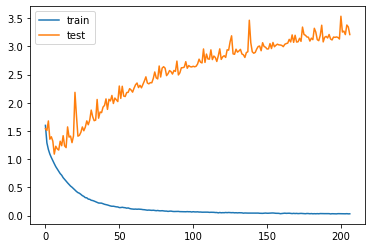

In [91]:
# define model

model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3, )))
model.add(L.Conv2D(filters=10, kernel_size=(3,3), activation="relu"))
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.BatchNormalization())
model.add(L.Flatten())
model.add(L.Dense(100, activation="relu"))
model.add(L.BatchNormalization())
model.add(L.Dense(10, activation="softmax"))

model.summary()

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)]

# fit model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=0, callbacks=callbacks)

# Возвращаемый объект "history" содержит записи
# значений потерь и метрик во время обучения

#print('\nhistory dict:', history.history)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [92]:
# Оценим модель на тестовых данных, используя "evaluate"
print('\n# Оцениваем на тестовых данных')
results = model.evaluate(X_test, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (results[1]*100))


# Оцениваем на тестовых данных
Accuracy: 58.29%


In [93]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
if test_acc > 0.55:
    print(" Not bad!")


 Test_acc = 0.5829
 Not bad!


### Прокомментируйте полученные результаты.

Практически сразу на линейном графике потери начали увеличиваться,
Это означает, что производительность модели не улучшалась, у нас не может быть самой эффективной или наиболее стабильной модели в конце обучения. 

Если я правильно понимаю, то кривая обученияэто результат функции, который показывает насколько верно работает сеть, сигмоид или парабола по которой монотонно растет увеличение метрики качества сети.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [47]:
# Set random seed for purposes of reproducibility

seed = 21

In [66]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3, )))
model.add(L.Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())
model.add(L.Conv2D(64, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())

model.add(L.Conv2D(64, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())
model.add(L.Conv2D(128, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())

model.add(L.Flatten())
model.add(L.Dropout(0.2))

model.add(L.Dense(256, kernel_constraint=maxnorm(3)))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())
model.add(L.Dense(128, kernel_constraint=maxnorm(3)))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.2))
model.add(L.BatchNormalization())

model.add(L.Dense(10, activation = 'softmax'))

epochs = 100
optimizer = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 16, 64)      

In [67]:
np.random.seed(seed)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=64)

Epoch 1/100
625/625 [==============================] - 210s 333ms/step - loss: 1.5775 - accuracy: 0.4394 - val_loss: 2.1688 - val_accuracy: 0.3033
Epoch 2/100
625/625 [==============================] - 220s 353ms/step - loss: 1.1029 - accuracy: 0.6055 - val_loss: 0.9315 - val_accuracy: 0.6710
Epoch 3/100
625/625 [==============================] - 232s 371ms/step - loss: 0.9148 - accuracy: 0.6770 - val_loss: 0.8106 - val_accuracy: 0.7103
Epoch 4/100
625/625 [==============================] - 238s 381ms/step - loss: 0.8017 - accuracy: 0.7204 - val_loss: 0.7553 - val_accuracy: 0.7402
Epoch 5/100
625/625 [==============================] - 232s 371ms/step - loss: 0.7367 - accuracy: 0.7412 - val_loss: 0.7102 - val_accuracy: 0.7513
Epoch 6/100
625/625 [==============================] - 230s 368ms/step - loss: 0.6890 - accuracy: 0.7560 - val_loss: 0.6810 - val_accuracy: 0.7643
Epoch 7/100
625/625 [==============================] - 223s 357ms/step - loss: 0.6514 - accuracy: 0.7721 - val_loss: 0

In [74]:
# Оценим модель на тестовых данных, используя "evaluate"
print('\n# Оцениваем на тестовых данных')
results = model.evaluate(X_test, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (results[1]*100))


# Оцениваем на тестовых данных
Accuracy: 83.72%


Момент истины: проверьте, какого качества достигла ваша сеть.

In [68]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=-1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8372
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 